In [1]:
import os
import env
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple

C:\Users\ERIC-PC2\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p
    def value(self, t): 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    def __init__(self, size, batch_size, prepare = 5):
        self.size = size
        self.memory = []
        self.idx = 0
        self.batch_size = batch_size
        self.prepare = prepare
        self.ready = False
        
    def add(self, *args):
        if len(self.memory) < self.size:
            self.memory.append(None)
        self.memory[self.idx] = Transition(*args)
        self.idx = (self.idx + 1) % self.size
        if(not self.ready and len(self.memory) > self.prepare * self.batch_size):
            self.ready = True
        
    def sample(self):
        return np.vstack(random.sample(self.memory, self.batch_size))
    
    def __len__(self):
        return len(self.memory)

In [5]:
class NN_layer:
    def __init__(self, input_layer, output_n, activation = None):
        batch_size, input_n = np.shape(input_layer)
        input_n = int(input_n)
        self.weight = tf.Variable(tf.random_uniform([input_n, output_n], -0.1, 0.1))
        self.bias = tf.Variable(tf.random_uniform([output_n], -0.1, 0.1))
        if(activation is not None):
            self.h = activation(tf.matmul(input_layer, self.weight) + self.bias)
        else:
            self.h =tf.matmul(input_layer, self.weight) + self.bias
        self.variables = [self.weight, self.bias]
    
    def construct_update(self, layer, tau):
        update = []
        for x, y in zip(self.variables, layer.variables):
            update.append(x.assign(x * tau + (1 - tau) * y))
        return update

In [20]:
class NAF_agent:
    def __init__(self, observation_space, action_space, 
                 learning_rate = 0.001, gamma = 0.8, tau = 0.99, 
                 annealing_steps=5000, s_epsilon = 1, f_epsilon = 0.1, 
                 hidden_size = 500, activation = tf.nn.relu, 
                 prepare = 200, batch_size = 256, memory_size = 500000, 
                 load_path = None):
        
        # Replay buffer and anneal exploration
        self.batch_size = batch_size
        self.memory = ReplayMemory(memory_size, batch_size, prepare)
        self.epsilon = LinearSchedule(annealing_steps, f_epsilon, s_epsilon)
        if(load_path is not None):
            self.steps = annealing_steps + 1
        else:
            self.steps = 0
        
        # Environment(Continuous space)
        self.state_n = observation_space
        self.action_n = action_space
        
        # Learning settings
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
           
        # NN settings
        H_n = hidden_size
        M_n = int((self.action_n) * (self.action_n + 1) / 2)
        V_n = 1
        mu_n = self.action_n
        tf.reset_default_graph()
        
        # NN structure
        self.x = tf.placeholder(shape = [None,self.state_n], dtype=tf.float32, name="state")
        self.u = tf.placeholder(shape = [None,self.action_n], dtype=tf.float32, name="action")
        self.target = tf.placeholder(shape=[None,1], dtype=tf.float32, name="target")
        
        # First hidden layer
        self.H = NN_layer(self.x, H_n, activation = activation) 
        self.t_H = NN_layer(self.x, H_n, activation = activation)
        self.updates = self.t_H.construct_update(self.H, self.tau)
        
        # Seconde hidden layer
        self.H = NN_layer(self.H.h, H_n, activation = activation)
        self.t_H = NN_layer(self.t_H.h, H_n, activation = activation)
        self.updates += self.t_H.construct_update(self.H, self.tau)
        
        # Output layer
        self.V = NN_layer(self.H.h, V_n)
        self.t_V = NN_layer(self.H.h, V_n)
        self.updates += self.t_V.construct_update(self.V, self.tau)
        self.mu = NN_layer(self.H.h, mu_n, activation = tf.nn.tanh)
        
        # NAF convariance
        self.M = NN_layer(self.H.h, M_n, activation = tf.nn.tanh)
        self.N = tf.contrib.distributions.fill_triangular(self.M.h)
        self.L = tf.matrix_set_diag(self.N, tf.exp(tf.matrix_diag_part(self.N)))
        self.P = tf.matmul(self.L, tf.matrix_transpose(self.L))

        # Q
        self.D = tf.reshape(self.u - self.mu.h, [-1, 1, self.action_n])
        self.A = (-0.5) * tf.reshape(tf.matmul(tf.matmul(self.D, self.P), tf.transpose(self.D, perm = [0, 2, 1])), [-1, 1])
        self.Q = self.A + self.V.h
        
        # Loss function
        self.loss = tf.losses.mean_squared_error(self.target, self.Q)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        # TF Session and GPU settings
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config = config)
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        # Load Network
        self.saver = tf.train.Saver()
        if(load_path is not None):
            self.saver.restore(self.sess, load_path)
        
    # Get action
    def get_action(self, s, episodes = 0):
        if(np.random.rand() < self.epsilon.value(self.steps)):
            if(episodes % 4 == 0):
                action = [random.uniform(0,1), random.uniform(0,1)]
            elif(episodes % 4 == 1):
                action = [random.uniform(-1,0), random.uniform(-1,0)]
            elif(episodes % 4 == 2):
                action = [random.uniform(0,1), random.uniform(-1,0)]
            else:
                action = [random.uniform(-1,0), random.uniform(0,1)]
        else:
            action = self.sess.run(self.mu.h, feed_dict = {self.x:np.reshape(s, [1,-1])})[0]
        return action
    
    def scale(self, actions, low, high):
        actions = np.clip(actions, -1, 1)
        scaled_actions = []
        for action in actions:
            scaled_actions.append((action + 1) * (high - low) / 2 + low)
        return np.reshape(scaled_actions, [-1])
    
    # Update target
    def update_target(self):
        for update in self.updates:
            self.sess.run(update)
    
    # Optimize model
    def optimize_model(self):
        if(self.memory.ready):
            batch = self.memory.sample()
            V = self.sess.run(self.t_V.h, feed_dict = {self.x:list(batch[:,3]), self.u:list(batch[:,1])})
            targets = batch[:,2] + self.gamma * V[range(self.batch_size), 0] * (-batch[:,4].astype(np.float32) + 1)
            targets  = np.reshape(targets, [-1,1])
            loss, advantage, _ = self.sess.run([self.loss, self.A, self.optimizer], feed_dict = {self.x:list(batch[:,0]), self.target:targets, self.u:list(batch[:,1])})
            self.update_target()
    
    # Updates steps fot epsilon
    def update_steps(self):
        if(self.memory.ready):
            self.steps += 1  
            
    # Model saver
    def save_Network(self, path = "./Network_save/NAF"):
        self.saver.save(self.sess, path)

In [7]:
def main_run(env = env.ArmEnv(), num_episodes=2000, train_freq = 100, view = True, threshold = 1000):

    # Agent and Env settings
    agent = NAF_agent(env.state_dim, env.action_dim)
    rewards = [0 for i in range(num_episodes)]
    episode_steps = []

    for i in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0

        while(not done and steps < threshold):
            if(view):
                env.render()
            action = agent.get_action(state, i)
            next_state, reward, done = env.step(action)
            agent.memory.add(state, action, reward, next_state, done)
            if(steps % train_freq == 0):
                agent.optimize_model()
            state = next_state
            rewards[i] += reward
            agent.update_steps()
            steps += 1
        episode_steps.append(steps)
        print(i, steps, done)
    if(view):
        env.close()
    agent.save_Network()
    return rewards, episode_steps, agent

In [7]:
%%time
# Train model
rewards, steps, agent = main_run(view = True)

0 1000 False
1 1000 False
2 1000 False
3 1000 False
4 1000 False
5 1000 False
6 1000 False
7 1000 False
8 1000 False
9 1000 False
10 1000 False
11 1000 False
12 1000 False
13 1000 False
14 1000 False
15 1000 False
16 1000 False
17 1000 False
18 1000 False
19 1000 False
20 1000 False
21 1000 False
22 1000 False
23 1000 False
24 1000 False
25 1000 False
26 1000 False
27 1000 False
28 1000 False
29 1000 False
30 1000 False
31 1000 False
32 1000 False
33 1000 False
34 1000 False
35 1000 False
36 1000 False
37 1000 False
38 1000 False
39 1000 False
40 1000 False
41 1000 False
42 1000 False
43 1000 False
44 1000 False
45 1000 False
46 1000 False
47 1000 False
48 1000 False
49 1000 False
50 1000 False
51 1000 False
52 1000 False
53 1000 False
54 1000 False
55 1000 False
56 1000 False
57 1000 False
58 1000 False
59 1000 False
60 1000 False
61 1000 False
62 1000 False
63 1000 False
64 1000 False
65 1000 False
66 1000 False
67 1000 False
68 1000 False
69 1000 False
70 1000 False
71 1000 False
72

603 1000 False
604 113 True
605 53 True
606 65 True
607 101 True
608 126 True
609 69 True
610 127 True
611 68 True
612 89 True
613 67 True
614 106 True
615 58 True
616 100 True
617 95 True
618 64 True
619 1000 False
620 214 True
621 79 True
622 101 True
623 92 True
624 129 True
625 72 True
626 1000 False
627 1000 False
628 141 True
629 83 True
630 78 True
631 97 True
632 116 True
633 100 True
634 1000 False
635 105 True
636 452 True
637 183 True
638 69 True
639 56 True
640 141 True
641 1000 False
642 84 True
643 61 True
644 1000 False
645 1000 False
646 103 True
647 76 True
648 209 True
649 125 True
650 80 True
651 77 True
652 80 True
653 54 True
654 64 True
655 58 True
656 129 True
657 73 True
658 64 True
659 80 True
660 1000 False
661 150 True
662 194 True
663 75 True
664 87 True
665 107 True
666 82 True
667 206 True
668 275 True
669 106 True
670 81 True
671 111 True
672 70 True
673 65 True
674 130 True
675 102 True
676 87 True
677 1000 False
678 64 True
679 53 True
680 1000 False
68

1232 1000 False
1233 111 True
1234 65 True
1235 107 True
1236 55 True
1237 64 True
1238 1000 False
1239 58 True
1240 159 True
1241 71 True
1242 62 True
1243 1000 False
1244 109 True
1245 122 True
1246 76 True
1247 58 True
1248 1000 False
1249 98 True
1250 53 True
1251 82 True
1252 120 True
1253 119 True
1254 76 True
1255 57 True
1256 58 True
1257 120 True
1258 79 True
1259 1000 False
1260 69 True
1261 79 True
1262 81 True
1263 126 True
1264 77 True
1265 322 True
1266 86 True
1267 129 True
1268 71 True
1269 58 True
1270 80 True
1271 92 True
1272 84 True
1273 69 True
1274 94 True
1275 63 True
1276 57 True
1277 66 True
1278 60 True
1279 62 True
1280 114 True
1281 79 True
1282 54 True
1283 77 True
1284 131 True
1285 115 True
1286 76 True
1287 82 True
1288 64 True
1289 76 True
1290 73 True
1291 54 True
1292 73 True
1293 117 True
1294 86 True
1295 71 True
1296 57 True
1297 70 True
1298 56 True
1299 951 True
1300 89 True
1301 83 True
1302 77 True
1303 108 True
1304 1000 False
1305 91 True
130

1838 71 True
1839 56 True
1840 84 True
1841 59 True
1842 72 True
1843 84 True
1844 252 True
1845 82 True
1846 56 True
1847 119 True
1848 60 True
1849 110 True
1850 94 True
1851 97 True
1852 106 True
1853 84 True
1854 546 True
1855 112 True
1856 113 True
1857 81 True
1858 141 True
1859 79 True
1860 1000 False
1861 82 True
1862 87 True
1863 81 True
1864 90 True
1865 57 True
1866 68 True
1867 64 True
1868 84 True
1869 169 True
1870 51 True
1871 66 True
1872 86 True
1873 82 True
1874 1000 False
1875 61 True
1876 78 True
1877 85 True
1878 63 True
1879 77 True
1880 94 True
1881 181 True
1882 61 True
1883 107 True
1884 71 True
1885 172 True
1886 1000 False
1887 53 True
1888 77 True
1889 87 True
1890 78 True
1891 95 True
1892 59 True
1893 1000 False
1894 1000 False
1895 62 True
1896 53 True
1897 87 True
1898 64 True
1899 89 True
1900 1000 False
1901 78 True
1902 99 True
1903 70 True
1904 960 True
1905 89 True
1906 112 True
1907 131 True
1908 118 True
1909 1000 False
1910 145 True
1911 83 True


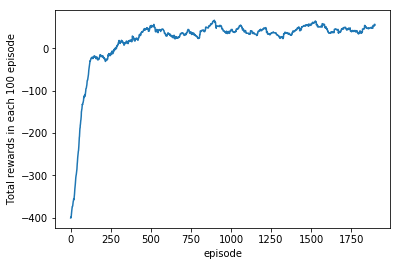

In [8]:
episode_rewards100 = np.zeros(len(rewards) - 100)
for i in range(len(rewards) - 100):
    for j in range(100):
        episode_rewards100[i] += rewards[i+j]
    episode_rewards100[i] /= 100
plt.plot(episode_rewards100)
plt.xlabel('episode')
plt.ylabel('Total rewards in each 100 episode')
plt.show()

# plt.bar(range(len(rewards)),rewards)
# plt.show()

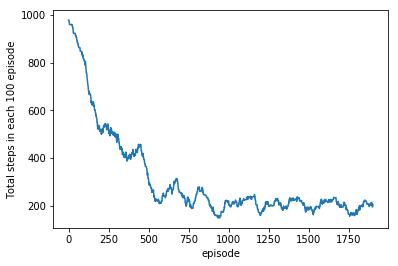

In [9]:
episode_steps100 = np.zeros(len(steps) - 100)
for i in range(len(steps) - 100):
    for j in range(100):
        episode_steps100[i] += steps[i+j]
    episode_steps100[i] /= 100
plt.plot(episode_steps100)
plt.xlabel('episode')
plt.ylabel('Total steps in each 100 episode')
plt.show()

In [23]:
ArmEnv = env.ArmEnv()
state = ArmEnv.reset()
Agent = NAF_agent(ArmEnv.state_dim, ArmEnv.action_dim, load_path = "./Network_save/NAF")

INFO:tensorflow:Restoring parameters from ./Network_save/NAF


In [30]:
i = 0
done = False
while(i < 3000):
    ArmEnv.render()
    action = Agent.get_action(state)
    state, _, done = ArmEnv.step(action)
    if(done):
        i += 1
ArmEnv.close()